In [1]:
import collections
from itertools import combinations

from fbprophet import Prophet
import holidays
import numpy as np
import pandas as pd
import pandahouse as ph
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Задание 1

##### Какие пары товаров пользователи покупают вместе чаще всего?

Считываем данные, после чего проверяем тип данных и есть ли пропущенные значения

In [2]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/409319/test1_completed.csv')

In [3]:
data.head()

,id,Товар,Количество
0,17119,Лимон,1.1
1,17119,Лимон оранжевый,0.7
2,17119,Лук-порей,10.0
3,17119,Лук репчатый,2.5
4,17119,Малина свежая,1.0


In [4]:
data.dtypes

id              int64
Товар          object
Количество    float64
dtype: object

In [5]:
data.isna().sum()

id            0
Товар         0
Количество    0
dtype: int64

Пропущенных значений нет, поэтому создаем список покупок, ищем пары товаров и сколько раз их купили

In [6]:
new_data = data.groupby('id')['Товар'].apply(list).sort_values()

In [7]:
table_with_food = collections.Counter()

for bucket in new_data:
    for food in combinations(bucket, 2):        

        table_with_food[food] += 1
    
df = pd.DataFrame.from_records(table_with_food.most_common(), columns=['Товар','Встречаемость'])
df

,Товар,Встречаемость
0,"(Огурцы Луховицкие, Укроп)",403
1,"(Петрушка, Укроп)",390
2,"(Арбуз, Огурцы Луховицкие)",314
3,"(Кабачки, Огурцы Луховицкие)",300
4,"(Кинза, Укроп)",290
...,...,...
39175,"(Яблоки Чемпион, Арбуз)",1
39176,"(Яблоки сезонные, Грибы вешенки)",1
39177,"(Папайя сушеная, Яблоки Симиренко)",1
39178,"(Яблоки сушеные, Грибы лисички)",1


Разбиваем пары товаров на две колонки и преобразуем табличку к финальному виду

In [8]:
df[['1_Товар','2_Товар']] = pd.DataFrame(df['Товар'].tolist(), index=df.index)

In [9]:
df = df[['1_Товар', '2_Товар', 'Встречаемость']]
top_5 = df.head(5).style.hide_index().set_caption('Топ 5 пар товаров')

#### Топ 5 пар товаров

In [10]:
top_5

1_Товар,2_Товар,Встречаемость
Огурцы Луховицкие,Укроп,403
Петрушка,Укроп,390
Арбуз,Огурцы Луховицкие,314
Кабачки,Огурцы Луховицкие,300
Кинза,Укроп,290


#### Вывод: 
Исходя из результатов, фирме можно рекомендовать:

Для увеличения чека/выручки Вам следует размещать зелень, овощи и фрукты рядом друг с другом.

# Задание 2

##### Построить (если возможно) прогноз продаж на следующие 3 месяца

Считываем данные и переименовываем колонки для дальнейшей работы с ними в Prophet

In [11]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv', parse_dates=[0])

In [12]:
df.rename(columns={'Дата':'ds', 'Число заказов': 'y'}, inplace=True)

In [13]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [14]:
df.head()

,ds,y
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489


Вкидываем праздники и неделю, когда была проведена массивная акция, для их учета моделькой

In [15]:
holidays_dict = holidays.RU(years=(2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays = df_holidays.rename({'index': 'ds', 0: 'holiday'}, axis='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)

In [16]:
spl_events_week = pd.DataFrame({
    'holiday': 'spl_events',
    'ds': pd.to_datetime(['2020-02-09']),
    'lower_window': -7,
    'upper_window': 0,
})

In [17]:
df_holidays = pd.concat((df_holidays, spl_events_week))

Период, который надо будет отрезать и предсказать для проверки модели.

In [18]:
predictions = 7

От обучающей выборки с конца отрезаем период, на котором будем проверять качетсво модели

In [19]:
train_df = df[:-predictions]

Настраиваем prophet – говорим ему учитывать праздники и сезонности и тренируем модельку

In [20]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_range=0.55)
m.fit(train_df)

INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


Предсказываем отрезанный нами период (7 недель) и смотрим, что предсказалось

In [21]:
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)

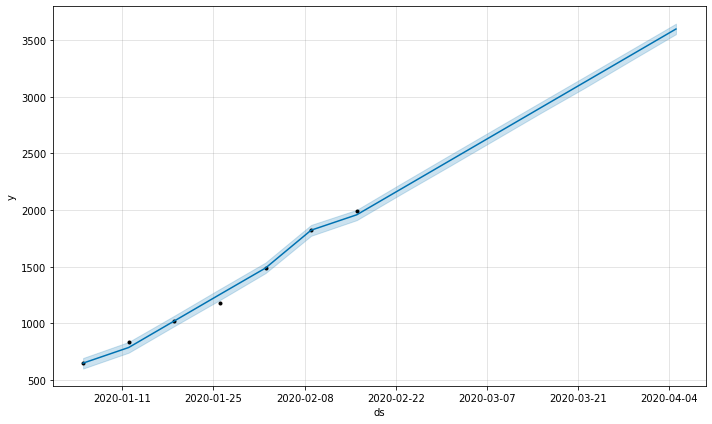

In [22]:
m.plot(forecast);

Смотрим на сезонности

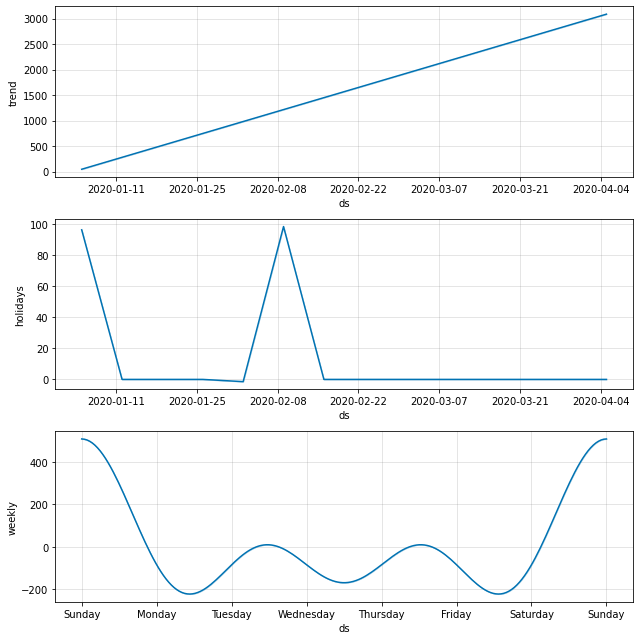

In [23]:
m.plot_components(forecast);

In [24]:
# Рисуем график с границами прогноза
init_notebook_mode(connected=True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

Считаем ошибки модели

In [25]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']

print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])), '%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  5.293137415094935 %
MAE (средняя абсолютная ошибка) –  171.55541502315828


Если нас устраивает % ошибки, то делаем прогноз на 3 месяца вперед и рисуем график

In [26]:
prediction_months = 3
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_months, freq='M')
final_forecast = f.predict(final_future)

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


In [27]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [28]:
final_forecast.rename(columns={'ds': 'Дата', 'yhat': 'Ожидаемое_кол-во_заказов'}, inplace=True)

Прогнозирование временного ряда о числе заказов с разрешением по неделям проводилось на интервале с 05.01.2020 до 05.04.2020. Для данного прогноза MAPE $\approx$ 5,29%. 

#### Прогноз на 3 месяца вперед:

In [29]:
final_forecast[['Дата', 'Ожидаемое_кол-во_заказов']].tail(3)

,Дата,Ожидаемое_кол-во_заказов
14,2020-04-30,4193.003643
15,2020-05-31,5827.015072
16,2020-06-30,6417.427074


#### Вывод: 
В данном случае, я бы посоветовала фирме рассмотреть влияние ковида на заказы, т.к. в середине марта уже начала появляться информация о том, что может быть локдаун - как за рубежом. В связи с чем, это может сказаться на заказы.

С 30 марта по 3 апреля уже была объявлена нерабочая неделя, ее можно было бы добавить как событие, чтобы моделька это учитывала и тогда прогноз может быть чуть точнее.

И в завершение, для более точного прогнозирования лучше брать данные за больший промежуток времени, а также стараться учитывать все сильные изменения, которые могут влиять на результат прогнозирования.

# Задание 3

##### Нужно написать запрос, чтобы получить таблицу со следующими колонками:

* purchase_date – дата покупки.
* purchase_id – id покупки
* client_id – id покупателя
* client_age – возраст покупателя
* client_registration_age – как долго человек пользуется вашими магазинами
* client_category – содержит new или old, если это первая или последующая покупка соответственно
* promotion_name – акция
* category_name – категория
* partner_name – партнёр
* client_city – город, где находится покупатель
* city – город
* revenue – сумма выручки
* quantity – число проданных единиц

Где поле status = 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

Подключаемся к БД project_variant_2

In [30]:
connection_default = {
    'host': 'http://clickhouse.lab.karpov.courses',
    'database':'project_variant_2',
    'user':'student', 
    'password':'dpo_python_2020',
}

Отправляем запрос и записываем результат в пандасовский датафрейм, с которым можно будет работать в дальнейшем.

In [31]:
query1 = '''
    SELECT 
        l.purchase_date AS purchase_date,
        l.purchase_id AS purchase_id,
        l.client_id,
        dateDiff('year', r1.birth_date, today()) AS client_age,
        round((dateDiff('month', r1.registration, max_date) / 12), 1) AS client_registration_age,
        CASE 
            WHEN l.purchase_date = ff.min_date THEN 'new'
            ELSE 'old'
        END AS client_category,
        promotion_name,
        category_name,
        partner_name,
        CAST(price AS Float) * CAST(quantity AS Int) AS revenue,
        CAST(quantity AS Int) AS quantity
    FROM {db}.purchase AS l

    LEFT JOIN {db}.client AS r1
    ON l.client_id = r1.client_id

    LEFT JOIN {db}.promotion AS r2
    ON l.promotion_id = r2.promotion_id

    LEFT JOIN 
        (
            SELECT 
                MIN(purchase_date) AS min_date,
                client_id
            FROM {db}.purchase
            GROUP BY client_id
        ) AS ff
        ON l.client_id = ff.client_id

    LEFT JOIN 
        (
            SELECT 
                MAX(purchase_date) AS max_date,
                client_id
            FROM {db}.purchase
            GROUP BY client_id
        ) AS fd
        ON l.client_id = fd.client_id 


    WHERE status = 1 AND 
          purchase_date BETWEEN '2020-05-01' AND '2020-08-01'

    '''


new_table1 = ph.read_clickhouse(query=query1, connection=connection_default)
new_table1

,purchase_date,purchase_id,l.client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,revenue,quantity
0,2020-06-05,0,853,29,1.3,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",150.0,5
1,2020-06-15,1,406,24,1.0,old,campaign_4,Прочее,KarpovCourses,1150.0,5
2,2020-08-01,9,867,25,0.3,old,campaign_1,Бакалея,Google,1840.0,4
3,2020-07-16,15,109,30,1.9,old,campaign_4,Прочее,KarpovCourses,440.0,8
4,2020-06-29,22,528,21,0.5,old,campaign_2,Фрукты,"ООО Ширяева, Хохлова и Тимофеева",390.0,2
...,...,...,...,...,...,...,...,...,...,...,...
2730,2020-07-28,8241,602,23,0.8,old,campaign_1,Бакалея,Google,780.0,6
2731,2020-07-15,8245,46,31,1.7,old,campaign_1,Бакалея,Google,2275.0,5
2732,2020-06-09,8246,954,25,0.6,old,campaign_4,Прочее,KarpovCourses,3120.0,8
2733,2020-08-01,8247,279,22,0.9,old,campaign_4,Прочее,KarpovCourses,735.0,7


In [32]:
# чтобы вывести табличку без индексов
# new_table.style.hide_index()